In [78]:
# Pre-Processing Part

import re
import nltk
nltk.download('stopwords')
import string
string.punctuation

stopword = nltk.corpus.stopwords.words('english')

def to_lower_case(text):
    return str(text).lower()

def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

def tokenize(text):
    split=re.split("\W+",text) 
    return split

def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text   


from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
import torch
import numpy as np
from sklearn import preprocessing
import pandas as pd

def sen_to_vec(sentence):
    tokens=tokenizer.tokenize(sentence)
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    T=52
    padded_tokens=tokens +['[PAD]' for _ in range(T-len(tokens))]
    attn_mask=[ 1 if token != '[PAD]' else 0 for token in padded_tokens  ]
    seg_ids=[0 for _ in range(len(padded_tokens))]
    sent_ids=tokenizer.convert_tokens_to_ids(padded_tokens)
    return np.array(sent_ids)

le = preprocessing.LabelEncoder()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AyanSau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
import pandas as pd
from sklearn.utils import shuffle
df_train=shuffle(pd.read_excel("Alldata.xlsx"))#.drop("Unnamed: 0",axis=1))

In [80]:
df_train.shape
df_train=df_train.dropna()

In [81]:
df_train.dtypes

name           object
Category       object
Is_Leasable      bool
dtype: object

In [82]:
df_train["Is_Leasable"]=df_train["Is_Leasable"].astype("str")
df_train.dtypes

name           object
Category       object
Is_Leasable    object
dtype: object

In [83]:
df_train=df_train.applymap(to_lower_case)
df_train=df_train.applymap(remove_punctuation)
df_train=df_train.applymap(tokenize)
df_train=df_train.applymap(remove_stopwords)
df_train=df_train.applymap(lambda x:" ".join(x))
df_train["sentence_vectors"]=df_train["name"].apply(sen_to_vec)
df_train["Is_Leasable"]=le.fit_transform(df_train["Is_Leasable"].values)
df_train=df_train.drop("Category",axis=1)
df_train.head()

,name,Is_Leasable,sentence_vectors
123,elevation graphic tee,0,"[101, 6678, 8425, 17170, 102, 0, 0, 0, 0, 0, 0..."
1684,villanova coolers,0,"[101, 6992, 13455, 14976, 2015, 102, 0, 0, 0, ..."
249,motorola focus50,1,"[101, 29583, 3579, 12376, 102, 0, 0, 0, 0, 0, ..."
1763,logo beanie,0,"[101, 8154, 14068, 2666, 102, 0, 0, 0, 0, 0, 0..."
393,motocare razr 2nd gen accident protection 2 years,0,"[101, 9587, 3406, 16302, 10958, 2480, 2099, 34..."


In [84]:
df_final_for_model=pd.concat([df_train.pop('sentence_vectors').apply(pd.Series), df_train['Is_Leasable']], axis=1)
df_final_for_model=df_final_for_model.fillna(0)
df_final_for_model.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,Is_Leasable
123,101,6678,8425,17170,102,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1684,101,6992,13455,14976,2015,102,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
249,101,29583,3579,12376,102,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1763,101,8154,14068,2666,102,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
393,101,9587,3406,16302,10958,2480,2099,3416,8991,4926,...,0,0,0,0,0,0,0,0,0,0


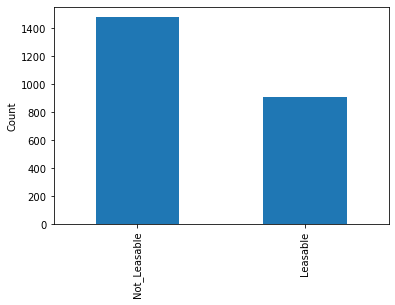

In [85]:
import matplotlib.pyplot as plt

# Visualize class distribution

df_final_for_model["Is_Leasable"].value_counts().plot(kind='bar')
plt.xticks([0,1], ['Not_Leasable', 'Leasable'])
plt.ylabel('Count');

In [86]:
X_train = df_final_for_model.drop("Is_Leasable",axis=1)[:int(0.80*len(df_final_for_model))]
y_train = df_final_for_model["Is_Leasable"][:int(0.80*len(df_final_for_model))]

X_test = df_final_for_model.drop("Is_Leasable",axis=1)[int(0.80*len(df_final_for_model)):len(df_final_for_model)]
y_test = df_final_for_model["Is_Leasable"][int(0.80*len(df_final_for_model)):len(df_final_for_model)]

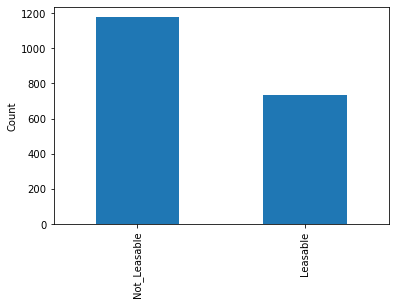

In [87]:
y_train.value_counts().plot(kind='bar')
plt.xticks([0,1], ['Not_Leasable', 'Leasable'])
plt.ylabel('Count');

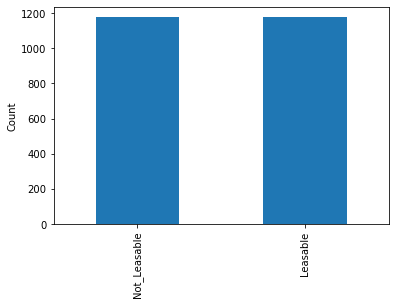

In [88]:
from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()

# fit and apply the transform
X_train, y_train = SMOTE.fit_resample(X_train, y_train)
y_train.value_counts().plot(kind='bar')
plt.xticks([0,1], ['Not_Leasable', 'Leasable'])
plt.ylabel('Count');

Train f1 Score: 0.47693920335429774
Test f1 Score: 0.35294117647058826


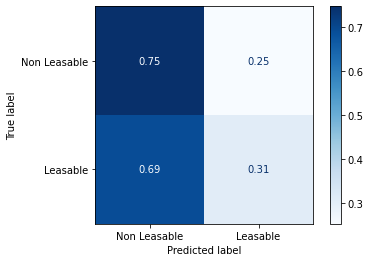

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
import pickle
filename="new_finalized_model.sav"
clf = MultinomialNB()

clf.fit(X_train, y_train)
y_hat_test = clf.predict(X_test)
y_hat_train = clf.predict(X_train)

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['Non Leasable', 'Leasable']);

pickle.dump(clf, open(filename, 'wb'))

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.43287612810830584)


In [92]:
y_pred = nbModel_grid.predict(X_test)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred), ": is the accuracy score")

from sklearn.metrics import precision_score
print(precision_score(y_test, y_pred), ": is the precision score")

from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred), ": is the recall score")

from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred), ": is the f1 score")

[[250  54]
 [129  46]] : is the confusion matrix
0.6179540709812108 : is the accuracy score
0.46 : is the precision score
0.26285714285714284 : is the recall score
0.33454545454545453 : is the f1 score


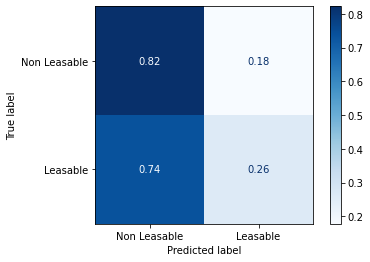

In [94]:
plot_confusion_matrix(nbModel_grid, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['Non Leasable', 'Leasable']);
